In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_date_item_no = pd.read_csv("assets/csv/df_date_item_no.csv", index_col=0)  # import data from csv
df_date_item_no = df_date_item_no.rename_axis('date', axis=1)
# change the datatype of the index to datetime
df_date_item_no.index = pd.to_datetime(df_date_item_no.index, format='%Y-%m-%d')

In [3]:
import re
# Enter Item name and order cycle
item_find = 'whole milk'
order_cycle = '2d'
#regex to find only digits
d = int(re.findall(r'\d+', order_cycle)[0])
num_pred = 365//d

In [4]:
df_resampled = df_date_item_no[[item_find,]].resample(order_cycle).sum()  # resample data to order cycle
print(df_resampled.head())
len(df_resampled)

date        whole milk
2014-01-01         6.0
2014-01-03         2.0
2014-01-05         7.0
2014-01-07        13.0
2014-01-09         1.0


365

In [5]:
#create a test train split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_resampled, test_size=0.2, shuffle=False)
len_train = len(train)
len_test = len(test)
print(f"Training Columns: {len_train}\nTesting Columns: {len_test}")

Training Columns: 292
Testing Columns: 73


In [6]:
df_item = pd.DataFrame({'ds':df_resampled.index, 'y':df_resampled[item_find].values})  # create dataframe for prophet (only accepts date as ds and value as y)
df_item.head()

,ds,y
0,2014-01-01,6.0
1,2014-01-03,2.0
2,2014-01-05,7.0
3,2014-01-07,13.0
4,2014-01-09,1.0


In [7]:
from prophet import Prophet  #Prophet by Facebook

model = Prophet()
# Fit the model
model.fit(df_item)

# create date to predict
future_dates = model.make_future_dataframe(periods=num_pred, freq=order_cycle)

# Make predictions
predictions = model.predict(future_dates)

predictions.tail()

23:18:18 - cmdstanpy - INFO - Chain [1] start processing
23:18:18 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
542,2016-12-20,10.315485,7.585353,15.127780,10.310843,10.319597,0.860690,0.860690,0.860690,0.860690,0.860690,0.860690,0.0,0.0,0.0,11.176175
543,2016-12-22,10.325070,6.180426,13.374163,10.320388,10.329244,-0.514519,-0.514519,-0.514519,-0.514519,-0.514519,-0.514519,0.0,0.0,0.0,9.810551
544,2016-12-24,10.334656,6.379498,13.639410,10.329933,10.338864,-0.254862,-0.254862,-0.254862,-0.254862,-0.254862,-0.254862,0.0,0.0,0.0,10.079794
545,2016-12-26,10.344241,6.224455,13.674625,10.339480,10.348483,-0.341411,-0.341411,-0.341411,-0.341411,-0.341411,-0.341411,0.0,0.0,0.0,10.002830
546,2016-12-28,10.353827,6.162163,13.614464,10.349031,10.358097,-0.346103,-0.346103,-0.346103,-0.346103,-0.346103,-0.346103,0.0,0.0,0.0,10.007724


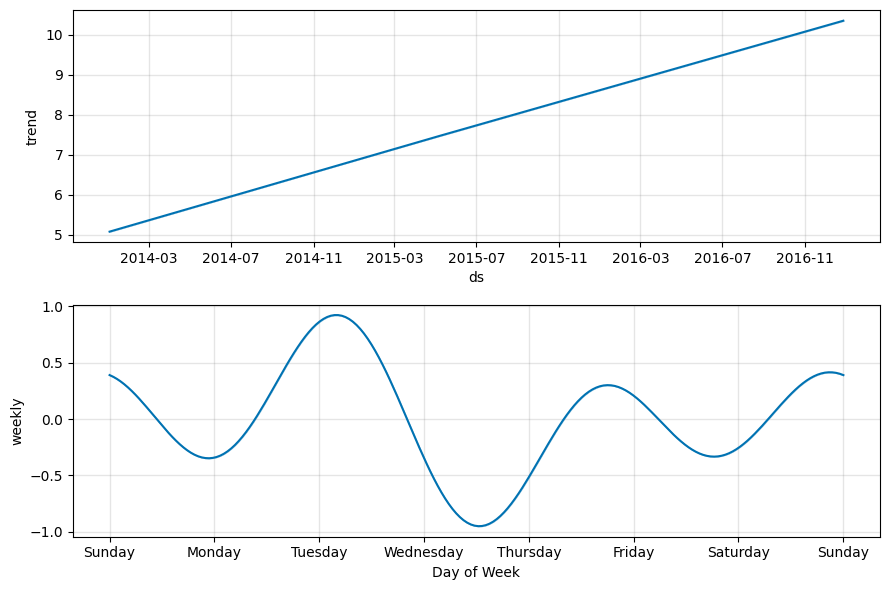

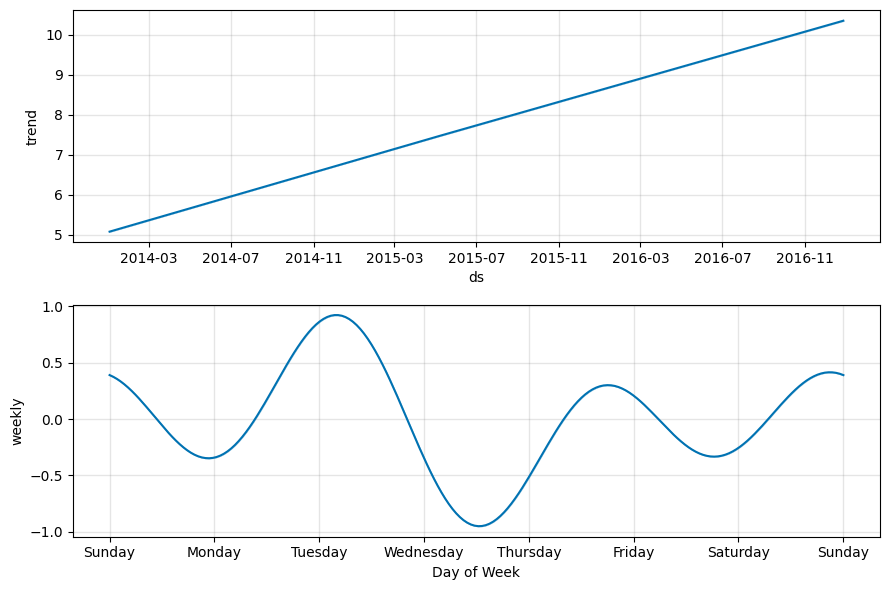

In [8]:
model.plot_components(predictions)

In [9]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial='365 days', horizon = '90 days')
res = performance_metrics(df_cv)
res

  0%|          | 0/7 [00:00<?, ?it/s]

23:18:19 - cmdstanpy - INFO - Chain [1] start processing
23:18:19 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:20 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing
23:18:21 - cmdstanpy - INFO - Chain [1] start processing
23:18:21 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,7.458115,2.730955,2.043374,0.314676,0.158026,0.271400,0.774194
1,10 days,5.098486,2.257983,1.739276,0.254965,0.148865,0.230971,0.806452
2,11 days,8.067604,2.840353,2.165460,0.295607,0.169023,0.272712,0.709677
3,12 days,8.051367,2.837493,2.166735,0.269330,0.258665,0.262859,0.709677
4,13 days,9.440761,3.072582,2.395609,0.355495,0.294084,0.307359,0.612903
...,...,...,...,...,...,...,...,...
77,86 days,17.884544,4.229012,2.773475,0.717838,0.178266,0.371984,0.693548
78,87 days,19.192799,4.380959,2.856353,0.687594,0.178266,0.364805,0.709677
79,88 days,18.491637,4.300190,2.822701,0.567994,0.178266,0.334645,0.750000
80,89 days,17.560083,4.190475,2.841536,0.408665,0.194926,0.328084,0.741935


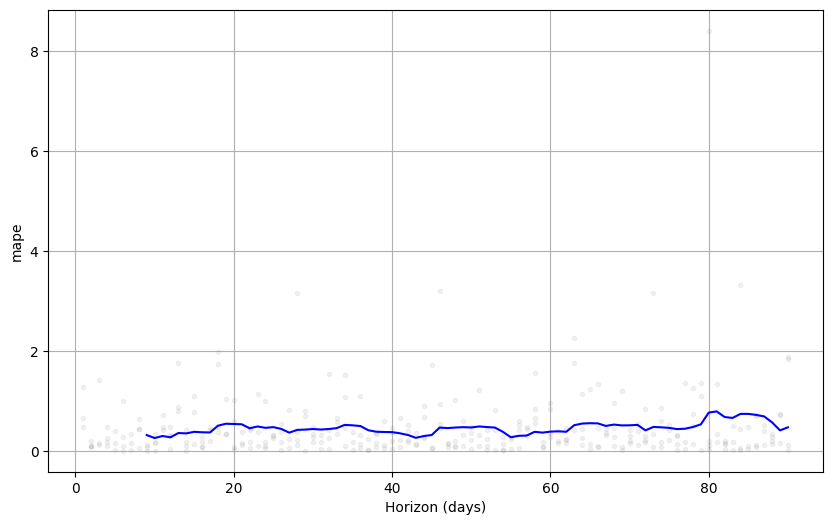

In [10]:
from prophet.plot import plot_cross_validation_metric
#choose between 'mse', 'rmse', 'mae', 'mape', 'coverage'
try:
    plot_cross_validation_metric(df_cv, metric= 'mape')
except TypeError:
    plot_cross_validation_metric(df_cv, metric= 'mdape', rolling_window=0.1)

In [11]:
print(f"MAE: {round(res.mae.median(),3)}")
print(f"RMSE: {round(res.rmse.median(),3)}")
try:
    print(f"MAPE: {round(res.mape.median(),3)}%")
except AttributeError:
    print(f"MDAPE: {round(res.mdape.median(),3)}%")

MAE: 2.712
RMSE: 3.365
MAPE: 0.456%


In [12]:
test_ = predictions[['ds','yhat_lower', 'yhat_upper', 'yhat']]
test_ = test_[test_.ds.isin(test.index)]
test_['y'] = test.values
for i in test_.index:
    lb =test_.loc[i, 'yhat_lower'] -  0.1*(test_.loc[i, 'yhat'])
    ub = test_.loc[i, 'yhat_upper'] + 0.1*(test_.loc[i, 'yhat'])
    if lb <= test_.loc[i, 'y'] <= ub:
        test_.loc[i, 'within_bounds'] = True
    else:
        test_.loc[i, 'within_bounds'] = False
accurate = test_.within_bounds.value_counts()[True]/len(test_)  #percentage of values within bounds
print(f"Percentage of Accurate predictions: {round(accurate, 5)*100}%")

Percentage of Accurate predictions: 79.452%


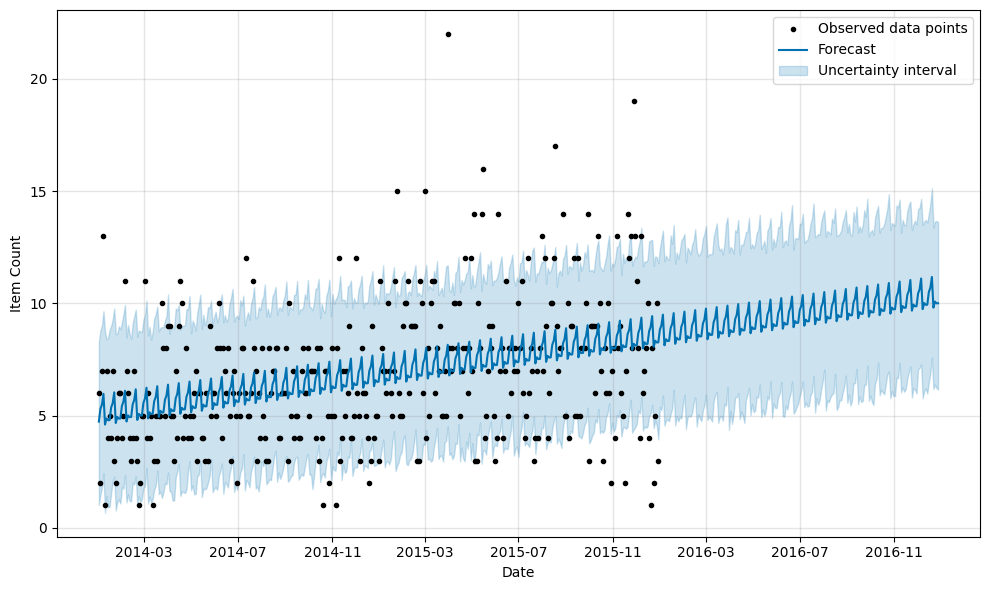

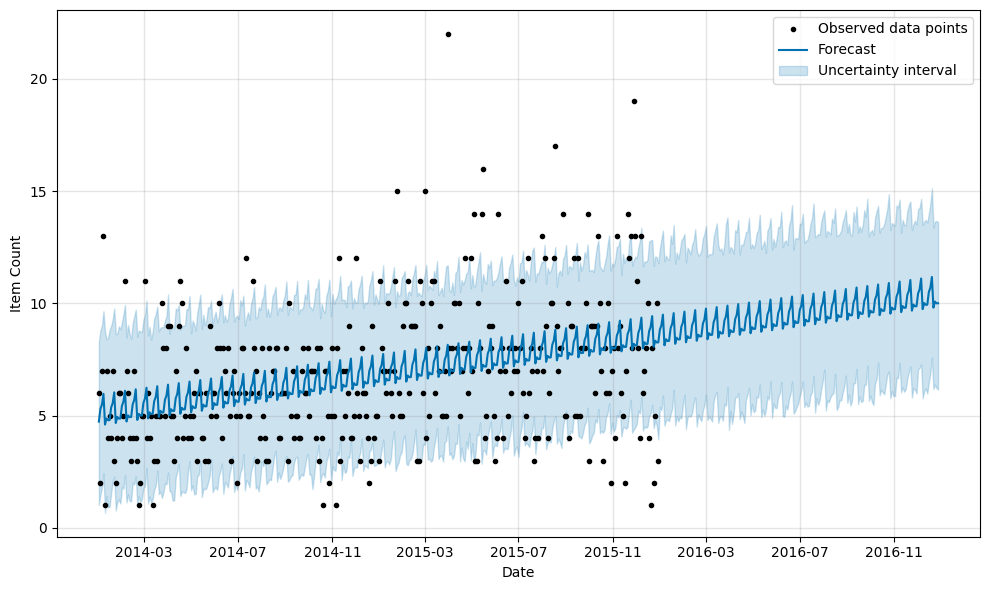

In [13]:
model.plot(predictions, xlabel = 'Date', ylabel = 'Item Count',include_legend=True, )

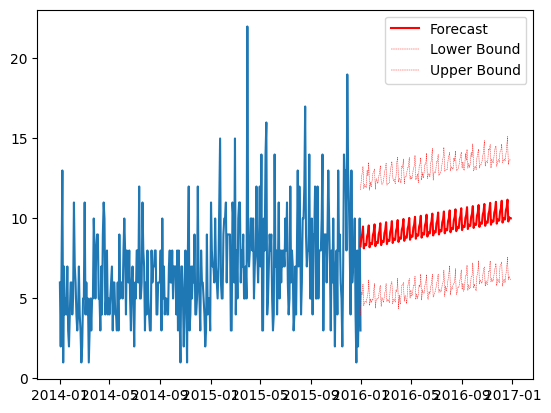

In [14]:
plt.plot(df_resampled)

prophet_forecast = pd.DataFrame(predictions[['yhat','yhat_lower', 'yhat_upper', 'ds']]).set_index('ds', drop=True).tail(num_pred+1)
plt.plot(prophet_forecast.yhat, label='Forecast', color='red')
plt.plot(prophet_forecast.yhat_lower, label='Lower Bound', color='red', linestyle='--', linewidth=0.3)
plt.plot(prophet_forecast.yhat_upper, label='Upper Bound', color='red', linestyle='--', linewidth=0.3)
plt.legend()
plt.show()